In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

In [2]:
data = pd.read_csv("trainLabels.csv")
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
data['image'] = [i+".png" for i in data['image'].values]
data.head()

,image,level
0,10_left.png,0
1,10_right.png,0
2,13_left.png,0
3,13_right.png,0
4,15_left.png,1


In [4]:
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

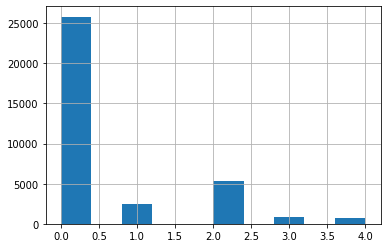

In [5]:
data['level'].hist()
data['level'].value_counts()

In [6]:
IMG_SIZE = 224

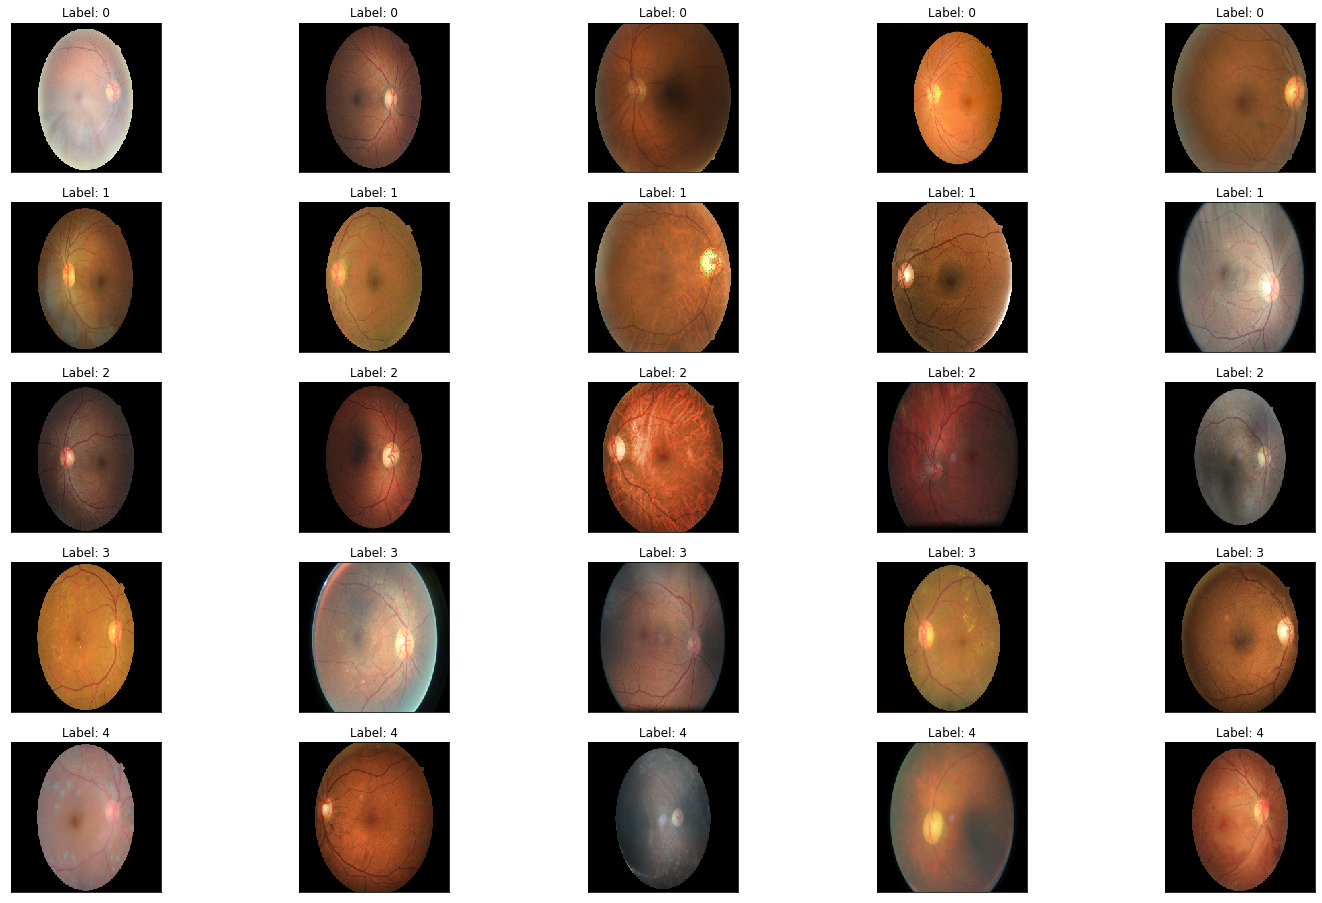

In [7]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in range(0,5):
    for i, (idx, row) in enumerate(data.loc[data['level'] == class_id].sample(5).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        image = cv2.imread("colored_image/{}".format(row['image']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %s' % (row['level']) )
        

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, val = train_test_split(data, test_size=0.15)

In [10]:
train.shape

(29857, 2)

In [11]:
def preprocess(image):
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

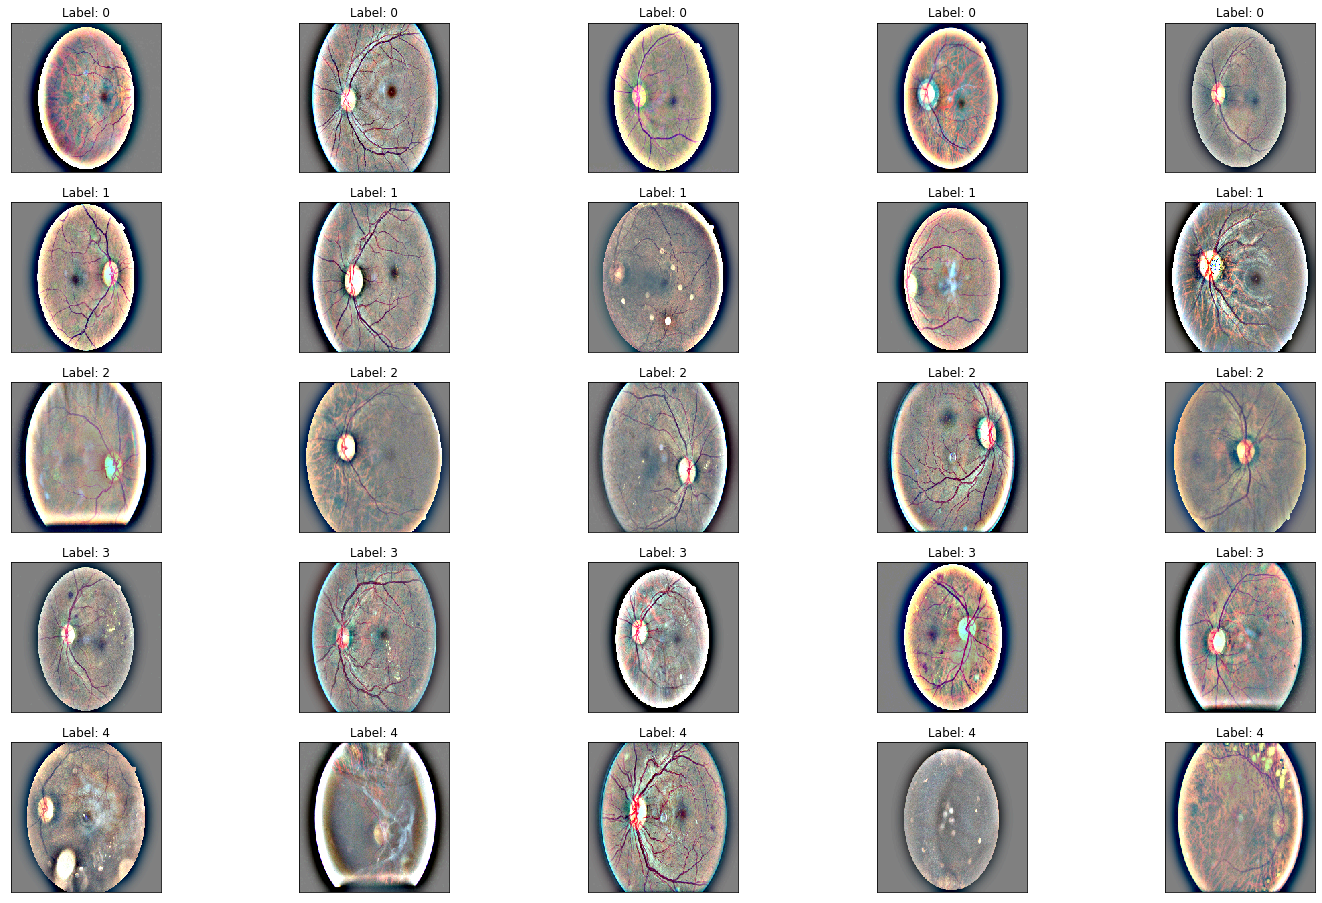

In [12]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in range(0,5):
    for i, (idx, row) in enumerate(data.loc[data['level'] == class_id].sample(5).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        image = cv2.imread("colored_image/{}".format(row['image']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = preprocess(image)
        plt.imshow(image)
        ax.set_title('Label: %s' % (row['level']) )
        

In [13]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [14]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.15,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=preprocess)

In [15]:
# batch size
bs = 32
train_gen = data_gen.flow_from_dataframe(train, 
                                         "colored_image/",
                                         x_col="image", y_col="level", class_mode="raw",
                                         batch_size=bs,
                                         target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val,
                                       "colored_image/",
                                       x_col="image", y_col="level", class_mode="raw",
                                       batch_size=bs,
                                       target_size=(224, 224))

Found 29857 validated image filenames.
Found 5269 validated image filenames.


### ResNet50

In [16]:
from keras.applications.resnet50 import ResNet50
import keras.layers as L
from keras.models import Model

In [17]:
base_model = ResNet50(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3))
x = base_model.output
x = L.GlobalMaxPooling2D()(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.2)(x)
x = L.Dense(1024, activation="relu")(x)
x = L.Dropout(0.1)(x)
x = L.Dense(64, activation="relu")(x)
predictions = L.Dense(5, activation='softmax')(x)

c:\users\parakh\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [18]:
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
for layer in base_model.layers[:-20]: layer.trainable = False

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [23]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model_chk = ModelCheckpoint("model.h5", save_best_only=True, monitor="val_accuracy")
reduce_lr = ReduceLROnPlateau()

In [20]:
model.fit_generator(train_gen, train_gen.n // bs,
                    validation_data=val_gen, validation_steps=val_gen.n // bs,
                    epochs=30, workers=4, callbacks=[model_chk])

Epoch 1/30
933/933 [==============================] - 658s 705ms/step - loss: 0.8304 - accuracy: 0.7334 - val_loss: 0.8007 - val_accuracy: 0.7372
Epoch 2/30
933/933 [==============================] - 639s 685ms/step - loss: 0.7639 - accuracy: 0.7448 - val_loss: 0.8354 - val_accuracy: 0.7388
Epoch 3/30
933/933 [==============================] - 635s 680ms/step - loss: 0.7417 - accuracy: 0.7510 - val_loss: 0.7128 - val_accuracy: 0.7371
Epoch 4/30
933/933 [==============================] - 634s 679ms/step - loss: 0.7307 - accuracy: 0.7534 - val_loss: 1.7067 - val_accuracy: 0.7384
Epoch 5/30
933/933 [==============================] - 630s 675ms/step - loss: 0.7274 - accuracy: 0.7543 - val_loss: 0.9492 - val_accuracy: 0.7395
Epoch 6/30
933/933 [==============================] - 628s 673ms/step - loss: 0.7181 - accuracy: 0.7575 - val_loss: 0.9978 - val_accuracy: 0.7374
Epoch 7/30
933/933 [==============================] - 631s 676ms/step - loss: 0.7112 - accuracy: 0.7611 - val_loss: 1.3209 -

In [24]:
from keras.models import load_model
model = load_model("model.h5")

Evaluate the results

In [25]:
test_df = data.groupby(['level']).apply(lambda x: x.sample(50, replace = True ).reset_index(drop = True))

In [26]:
targets_series = pd.Series(test_df['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [27]:
one_hot_labels = np.asarray(one_hot)
x_test=[]
y_test=[]

In [28]:
from tqdm import *
i = 0 
for f, breed in tqdm(test_df.values):
    img = cv2.imread('colored_image/{}'.format(f)) 
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = preprocess(img)
    arr = np.array(img, dtype="float") / 255.0
    label = one_hot_labels[i]
    x_test.append(arr)
    y_test.append(label)
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 23.04it/s]


In [29]:
y_test= np.array(y_test)
x_test= np.array(x_test)

In [30]:
x_test.shape , y_test.shape

((250, 224, 224, 3), (250, 5))

In [31]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(x_test, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(y_test, -1)

250/250 [==============================] - 98s 390ms/step


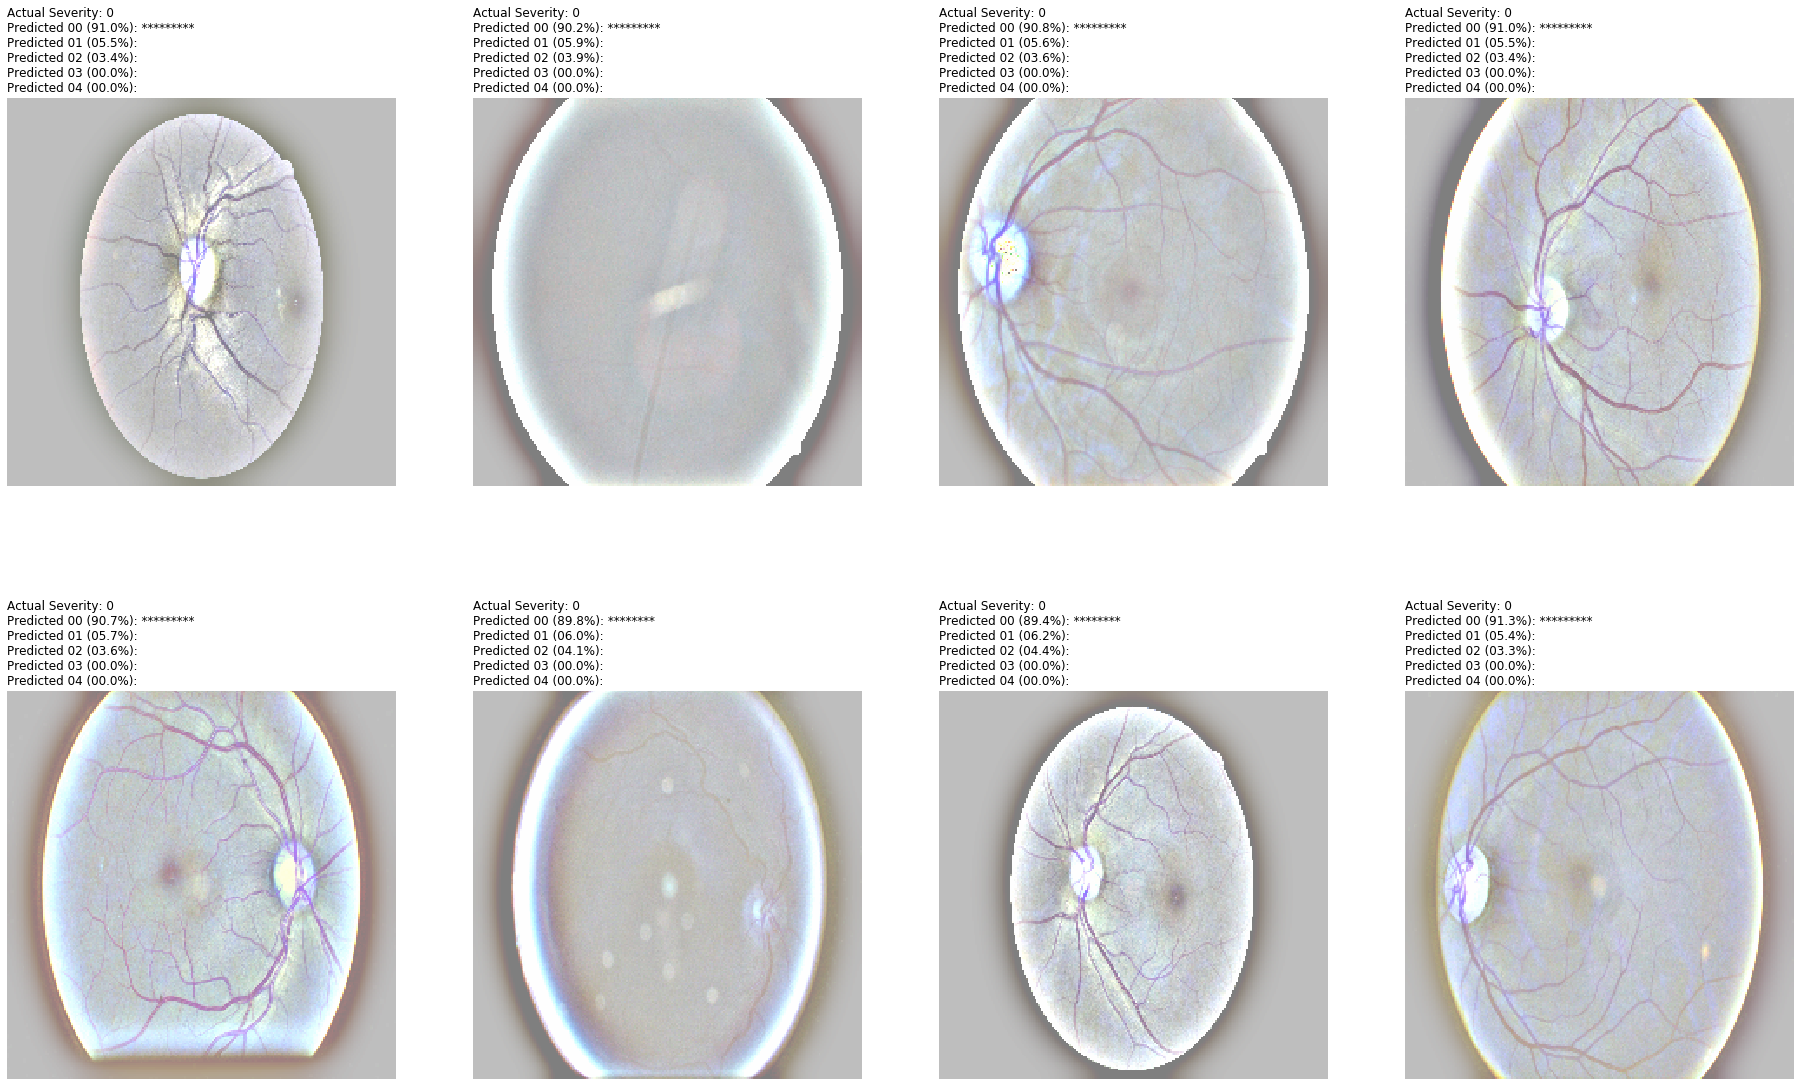

In [32]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(x_test[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

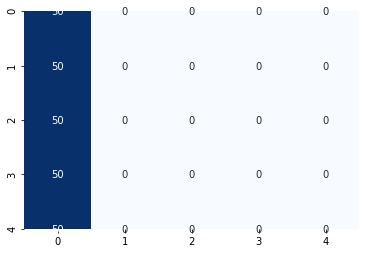

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = x_test.shape[0]//16)